![pngCurso.png](attachment:pngCurso.png)

# Estrategias de implementación

## Redes neuronales usando Keras: Implementación en contexto real usando Keras

## Actividad calificada por el personal

### Propósito

En el laboratorio "Estimación de red neuronal con múltiples capas" se propuso una implementación manual de redes neuronales usando librerías básicas de python como lo son *pandas* y *numpy*. *Google* desarrolló un *API* para el aprendizaje automático cuyo nombre es *"Keras"*, esta es escrita en *python* y es utilizada para hacer implementaciones de redes neuronales simples.

Así, en este *notebook* se pretende evaluar el uso de *keras* al aplicar una red neuronal en un contexto real.

### Instrucciones generales

1. Para desarrollar el notebook, lo deberán descargar a un repositorio (pueden escoger el repositorio de su preferencia) para que lo puedan trabajar grupalmente.

2. Los procedimientos en el notebook deberán responderse en los espacios especificados para tal fin, debajo de cada uno de los puntos.

3. Para que la actividad sea calificada, deberán subir únicamente este mismo archivo con la extensión ".ipynb" a la actividad de "entrega calificada por el personal" correspondiente a este caso.

4. El archivo que suban debe poder ejecutarse localmente cuando sea descargado por el tutor, asumiendo que la base de datos de la actividad ya ha sido importada en el correspondiente archivo separado por comas (.csv).

### Criterios a evaluar

Los criterios que se evaluarán son:

Análisis preliminar de variables: Se presentan correlogramas, histogramas y estadísticas descriptivas de las variables de la base de datos y se hace un análisis coherente de cada uno de ellos. [30 puntos]

Estimación de un modelo utilizando redes neuronales: Se estima el modelo usando una red neuronal, se evalúa en la muestra de test y se analizan correctamente los resultados y el procedimiento realizado [30 puntos]

Elección del mejor modelo: Se elige la mejor combinación de hiperparámetros de acuerdo a los resultados obtenidos y justifica adecuadamente la selección. [40 puntos]


#### Problema

Un *manager* de un banco manifiesta preocupación porque los clientes están renunciando a las tarjetas de crédito. Este cuenta con los datos disponibles en
https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers a cerca de 10000 clientes, si tiene productos activos o no (*"Attrition flag"*), en función de variables tales como edad, salario, estado civil, límite de tarjeta de crédito, categoría de tarjeta de crédito, etc.

Ustedes deben proponer el algoritmo para hacer la clasificación de los clientes con una red neuronal.

Tengan en cuenta que, para resolver los puntos de esta actividad, únicamente deben considerar las variables continuas (se deben eliminar las variables categóricas) y deberán eliminar las observaciones con datos faltantes.


### Librerías a importar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import exp
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, activations, regularizers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Input, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

import tensorflow as tf
import random
import os
seed_value = 123
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
# Plots
def plot_histograms(dataframe):
    # Get the column names of the DataFrame
    columns = dataframe.columns
    # Set up the number of rows and columns for subplots
    num_cols = len(columns)
    num_rows = (num_cols // 3) + (num_cols % 3 > 0)
    # Set up the figure and axes
    fig, axes = plt.subplots(num_rows, 3, figsize=(16, 4 * num_rows))
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between subplots
    # Flatten the 2D array of axes to simplify indexing
    axes = axes.flatten()
    # Loop through each column and plot the histogram
    for i, column in enumerate(columns):
        ax = axes[i]
        sns.histplot(dataframe[column], ax=ax, kde = True)
        ax.set_title(f'Histograma de {column}')
    # Remove empty subplots if needed
    for i in range(num_cols, num_rows * 3):
        fig.delaxes(axes[i])
    plt.show()

def plot_boxplots_vscat(dataframe,target):
    # Get the column names of the DataFrame
    columns = dataframe.select_dtypes(include=['number']).columns
    # Set up the number of rows and columns for subplots
    num_cols = len(columns)
    num_rows = (num_cols // 2) + (num_cols % 2 > 0)  # Change 4 to 3
    # Set up the figure and axes
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 4 * num_rows), sharey='row')  # Change 4 to 3
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between subplots
    # Flatten the 2D array of axes to simplify indexing
    axes = axes.flatten()

    # Loop through each column and plot the boxplot with hue
    for i, column in enumerate(columns):
        ax = axes[i]
        sns.boxplot(x=dataframe[column], y=target, ax=ax)
        ax.set_title(f'Boxplot of {column}')

    # Remove empty subplots if needed
    for i in range(num_cols, num_rows * 2):
        fig.delaxes(axes[i])
    plt.show()


### 0. Carga de datos


In [3]:
url= "https://raw.githubusercontent.com/alebarbosac-da/DL_W3_S2TCPEP2/refs/heads/main/BankChurners.csv"
data_raw = pd.read_csv(url, sep=",")
data_raw.head(3)

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   

[3 rows x 23 columns]

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [5]:
cat_var = list(data_raw.select_dtypes(include=['object']).columns)
columns_to_drop = cat_var[1:] + [
    'CLIENTNUM',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
    ]
columns_to_drop

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'CLIENTNUM',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

In [6]:
data = data_raw.drop(columns=columns_to_drop)

### 1. Análisis preliminar de variables [30 puntos]

Realicen un análisis preliminar de los predictores y de la variable de respuesta (correlogramas, histogramas y estadísticas descriptivas).

#### Diccionario de Datos


| **Variable**                     | **Descripción**                                                                                                                                                                                                                         |
|----------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| CLIENTNUM                        | Identificador único de cada cliente.                                                                                                                                                                                                   |
| Attrition_Flag                   | Indicador que muestra si el cliente es un cliente existente o ha abandonado (cliente desvinculado).                                                                                                                                        |
| Customer_Age                     | Edad del cliente en años.                                                                                                                                                                                                               |
| Gender                           | Género del cliente (típicamente "Masculino" o "Femenino").                                                                                                                                                                              |
| Dependent_count                  | Número de dependientes que tiene el cliente.                                                                                                                                                                                            |
| Education_Level                  | Nivel educativo más alto alcanzado por el cliente (por ejemplo, Secundaria, Universitario, etc.).                                                                                                                                       |
| Marital_Status                   | Estado civil del cliente (por ejemplo, Soltero, Casado, Divorciado).                                                                                                                                                                    |
| Income_Category                  | Categoría o rango de ingresos en el que se encuentra el cliente (por ejemplo, "<$40K", "$40K-$60K", etc.).                                                                                                                               |
| Card_Category                    | Categoría o tipo de tarjeta de crédito que posee el cliente (por ejemplo, Blue, Silver, Gold, Platinum).                                                                                                                                  |
| Months_on_book                   | Número de meses que el cliente ha estado vinculado al banco.                                                                                                                                                                            |
| Total_Relationship_Count         | Número total de productos que el cliente tiene con el banco (por ejemplo, cuentas de ahorro, tarjetas de crédito, préstamos, etc.).                                                                                                      |
| Months_Inactive_12_mon           | Número de meses en los últimos 12 meses en que el cliente no usó ninguno de los productos del banco.                                                                                                                                     |
| Contacts_Count_12_mon            | Número de contactos o interacciones realizados con el cliente en los últimos 12 meses (por ejemplo, llamadas, correos electrónicos, visitas a la sucursal).                                                                          |
| Credit_Limit                     | Límite máximo de crédito asignado al cliente.                                                                                                                                                                                          |
| Total_Revolving_Bal              | Balance total de crédito revolvente que lleva el cliente, representando el monto adeudado en crédito renovable (como las tarjetas de crédito).                                                                                          |
| Avg_Open_To_Buy                  | Monto promedio disponible para que el cliente gaste, calculado como el límite de crédito menos el balance.                                                                                                                               |
| Total_Trans_Amt                  | Monto total de transacciones realizadas por el cliente en los últimos 12 meses.                                                                                                                                                          |
| Total_Trans_Ct                   | Número total de transacciones realizadas por el cliente en los últimos 12 meses.                                                                                                                                                         |
| Avg_Utilization_Ratio            | Proporción del balance total de crédito revolvente respecto al límite de crédito, promediado durante un período (usualmente expresado como porcentaje).                                                                                 |
| Total_Amt_Chng_Q4_Q1         | Cambio total en el monto de transacciones de Q4 a Q1. Este valor indica la variación en el gasto del cliente entre el cuarto y el primer trimestre, normalmente expresado en relación con el gasto del primer trimestre.       |
| Total_Ct_Chng_Q4_Q1         | Cambio total en el número de transacciones de Q4 a Q1. Este valor refleja la variación en la frecuencia de transacciones realizadas por el cliente entre el cuarto y el primer trimestre, usualmente en comparación con el Q1. |

### Explicaciones de variables


**Total_Trans_Amt**: *(Total transaction amount)*, monto total de dinero que el cliente ha transaccionado

**Total_Trans_Ct**: *(Total transaction count)*, número total de transacciones realizadas por el cliente

**Total_Ct_Chng_Q4_Q1**: *(Total Count Change from Q4 to Q1))*, cambio porcentual o absoluto en la cantidad de transacciones del cliente desde el cuarto trimestre (Q4) al primer trimestre (Q1).

**Avg_Utilization_Ratio**: *(Average Utilization Ratio)*, Promedio del ratio de utilización del crédito, es decir, cuánto del crédito disponible está usando el cliente

In [7]:
data.isna().sum()

Attrition_Flag              0
Customer_Age                0
Dependent_count             0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [8]:
data.describe().T

count         mean          std     min       25%  \
Customer_Age              10127.0    46.325960     8.016814    26.0    41.000   
Dependent_count           10127.0     2.346203     1.298908     0.0     1.000   
Months_on_book            10127.0    35.928409     7.986416    13.0    31.000   
Total_Relationship_Count  10127.0     3.812580     1.554408     1.0     3.000   
Months_Inactive_12_mon    10127.0     2.341167     1.010622     0.0     2.000   
Contacts_Count_12_mon     10127.0     2.455317     1.106225     0.0     2.000   
Credit_Limit              10127.0  8631.953698  9088.776650  1438.3  2555.000   
Total_Revolving_Bal       10127.0  1162.814061   814.987335     0.0   359.000   
Avg_Open_To_Buy           10127.0  7469.139637  9090.685324     3.0  1324.500   
Total_Amt_Chng_Q4_Q1      10127.0     0.759941     0.219207     0.0     0.631   
Total_Trans_Amt           10127.0  4404.086304  3397.129254   510.0  2155.500   
Total_Trans_Ct            10127.0    64.858695    23.472570    10.0    45.000   
Total_Ct_Chng_Q4_Q1       10127.0     0.712222     0.238086     0.0     0.582   
Avg_Utilization_Ratio     10127.0     0.274894     0.275691     0.0     0.023   

                               50%        75%        max  
Customer_Age                46.000     52.000     73.000  
Dependent_count              2.000      3.000      5.000  
Months_on_book              36.000     40.000     56.000  
Total_Relationship_Count     4.000      5.000      6.000  
Months_Inactive_12_mon       2.000      3.000      6.000  
Contacts_Count_12_mon        2.000      3.000      6.000  
Credit_Limit              4549.000  11067.500  34516.000  
Total_Revolving_Bal       1276.000   1784.000   2517.000  
Avg_Open_To_Buy           3474.000   9859.000  34516.000  
Total_Amt_Chng_Q4_Q1         0.736      0.859      3.397  
Total_Trans_Amt           3899.000   4741.000  18484.000  
Total_Trans_Ct              67.000     81.000    139.000  
Total_Ct_Chng_Q4_Q1          0.702      0.818      3.714  
Avg_Utilization_Ratio        0.176      0.503      0.999

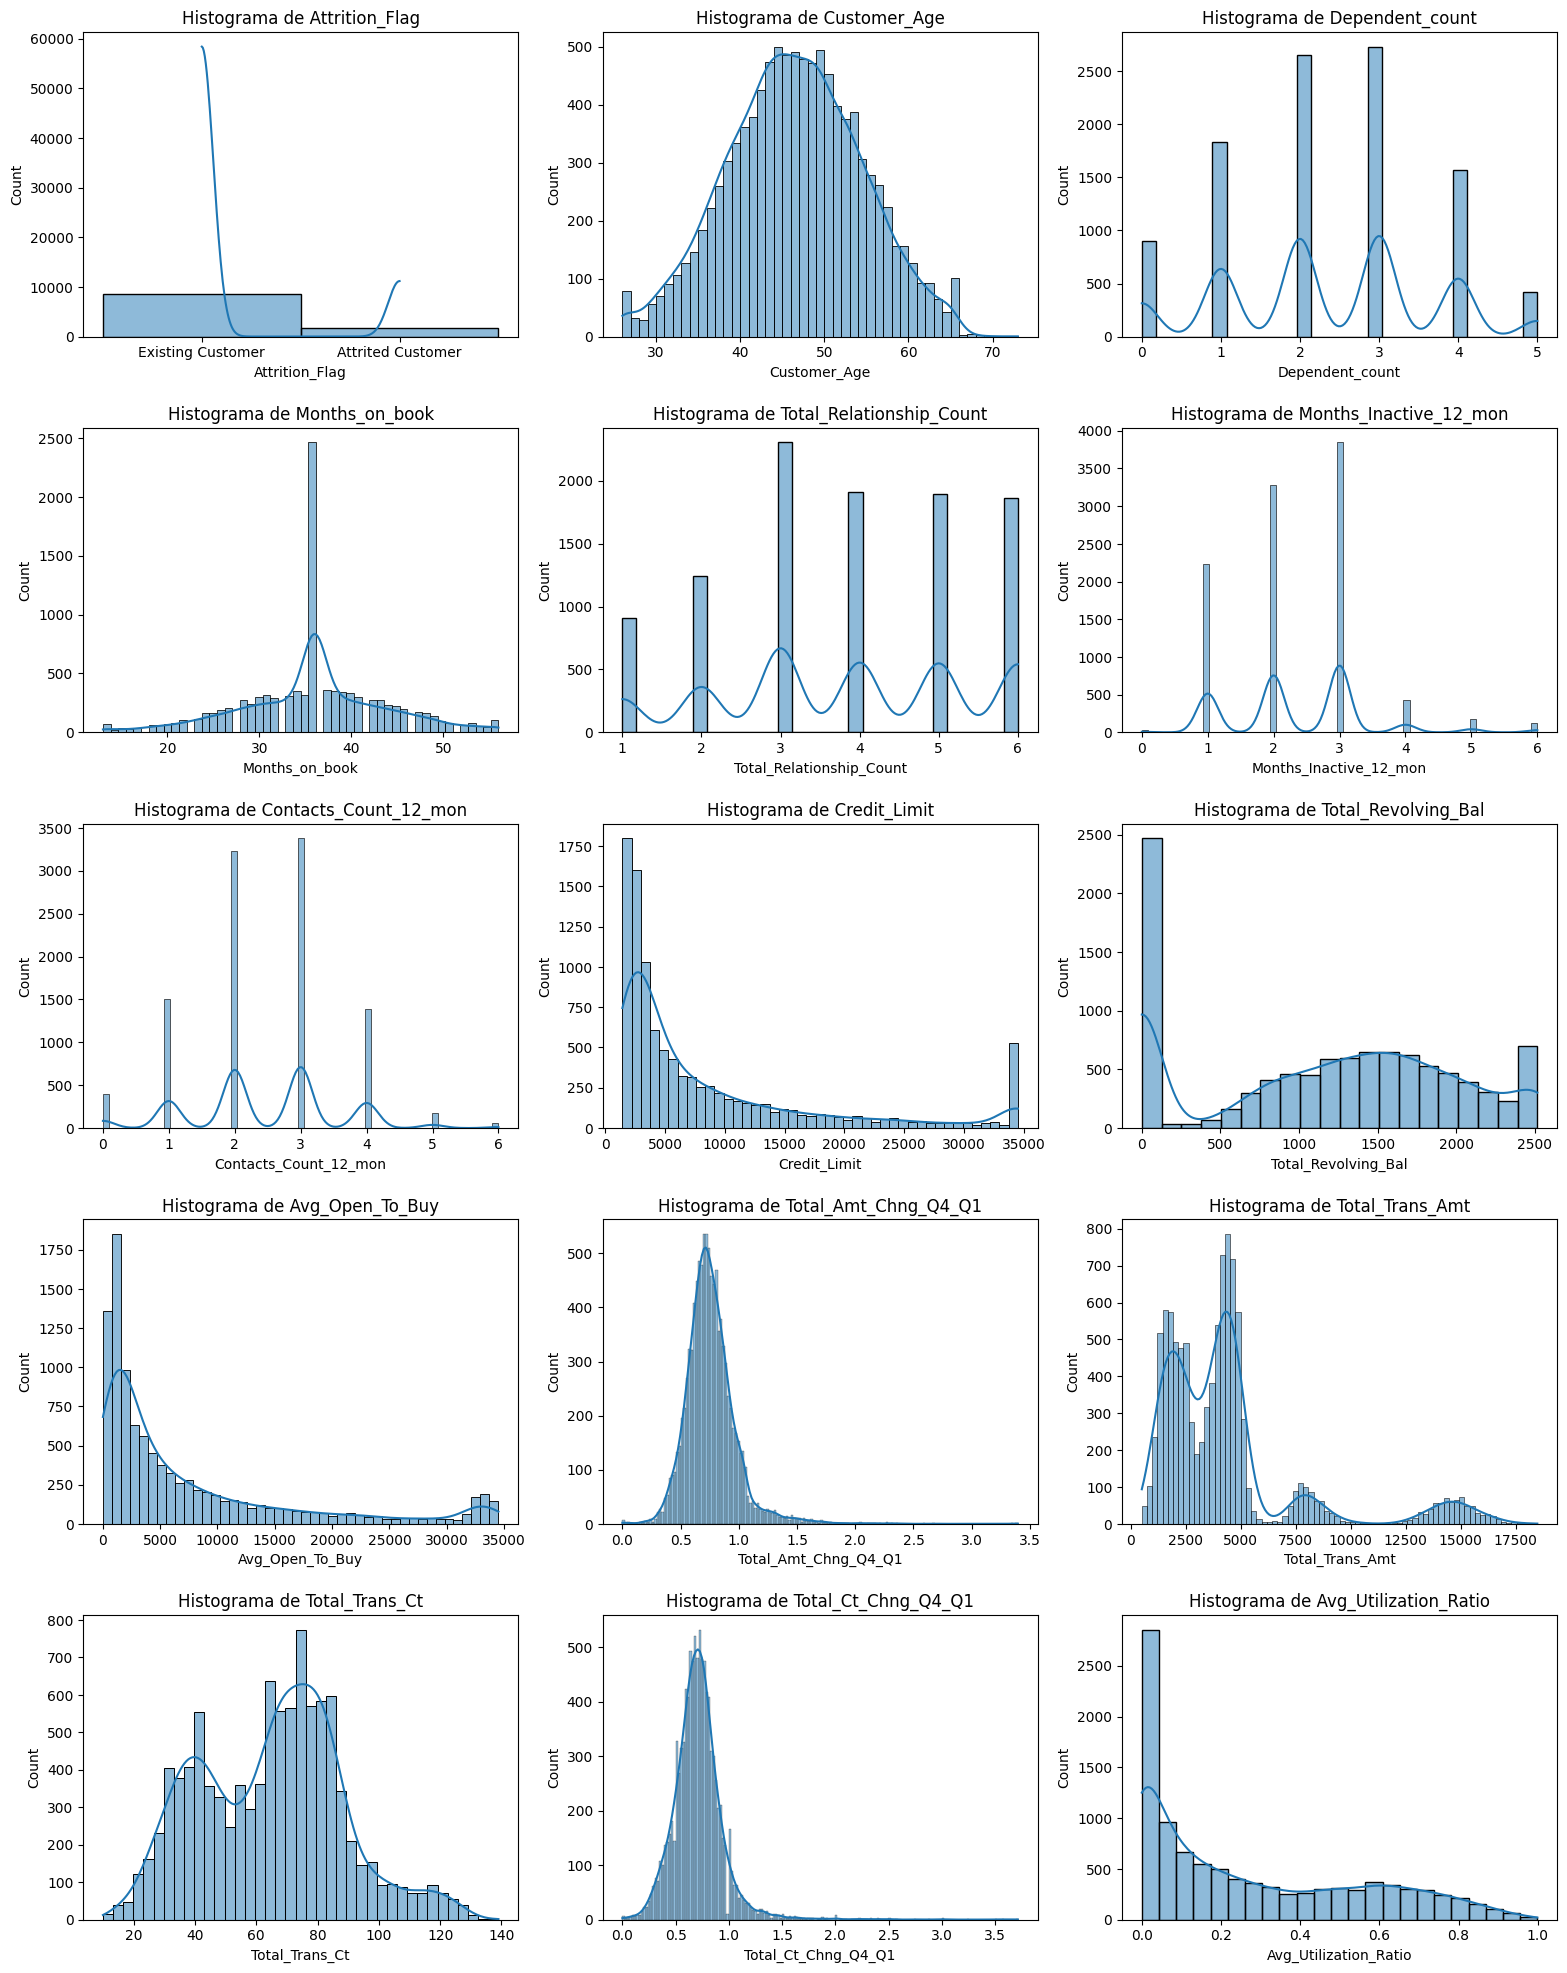

In [9]:
plot_histograms(data)

In [10]:
variables_cat =['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']
data = data.drop(columns=variables_cat)

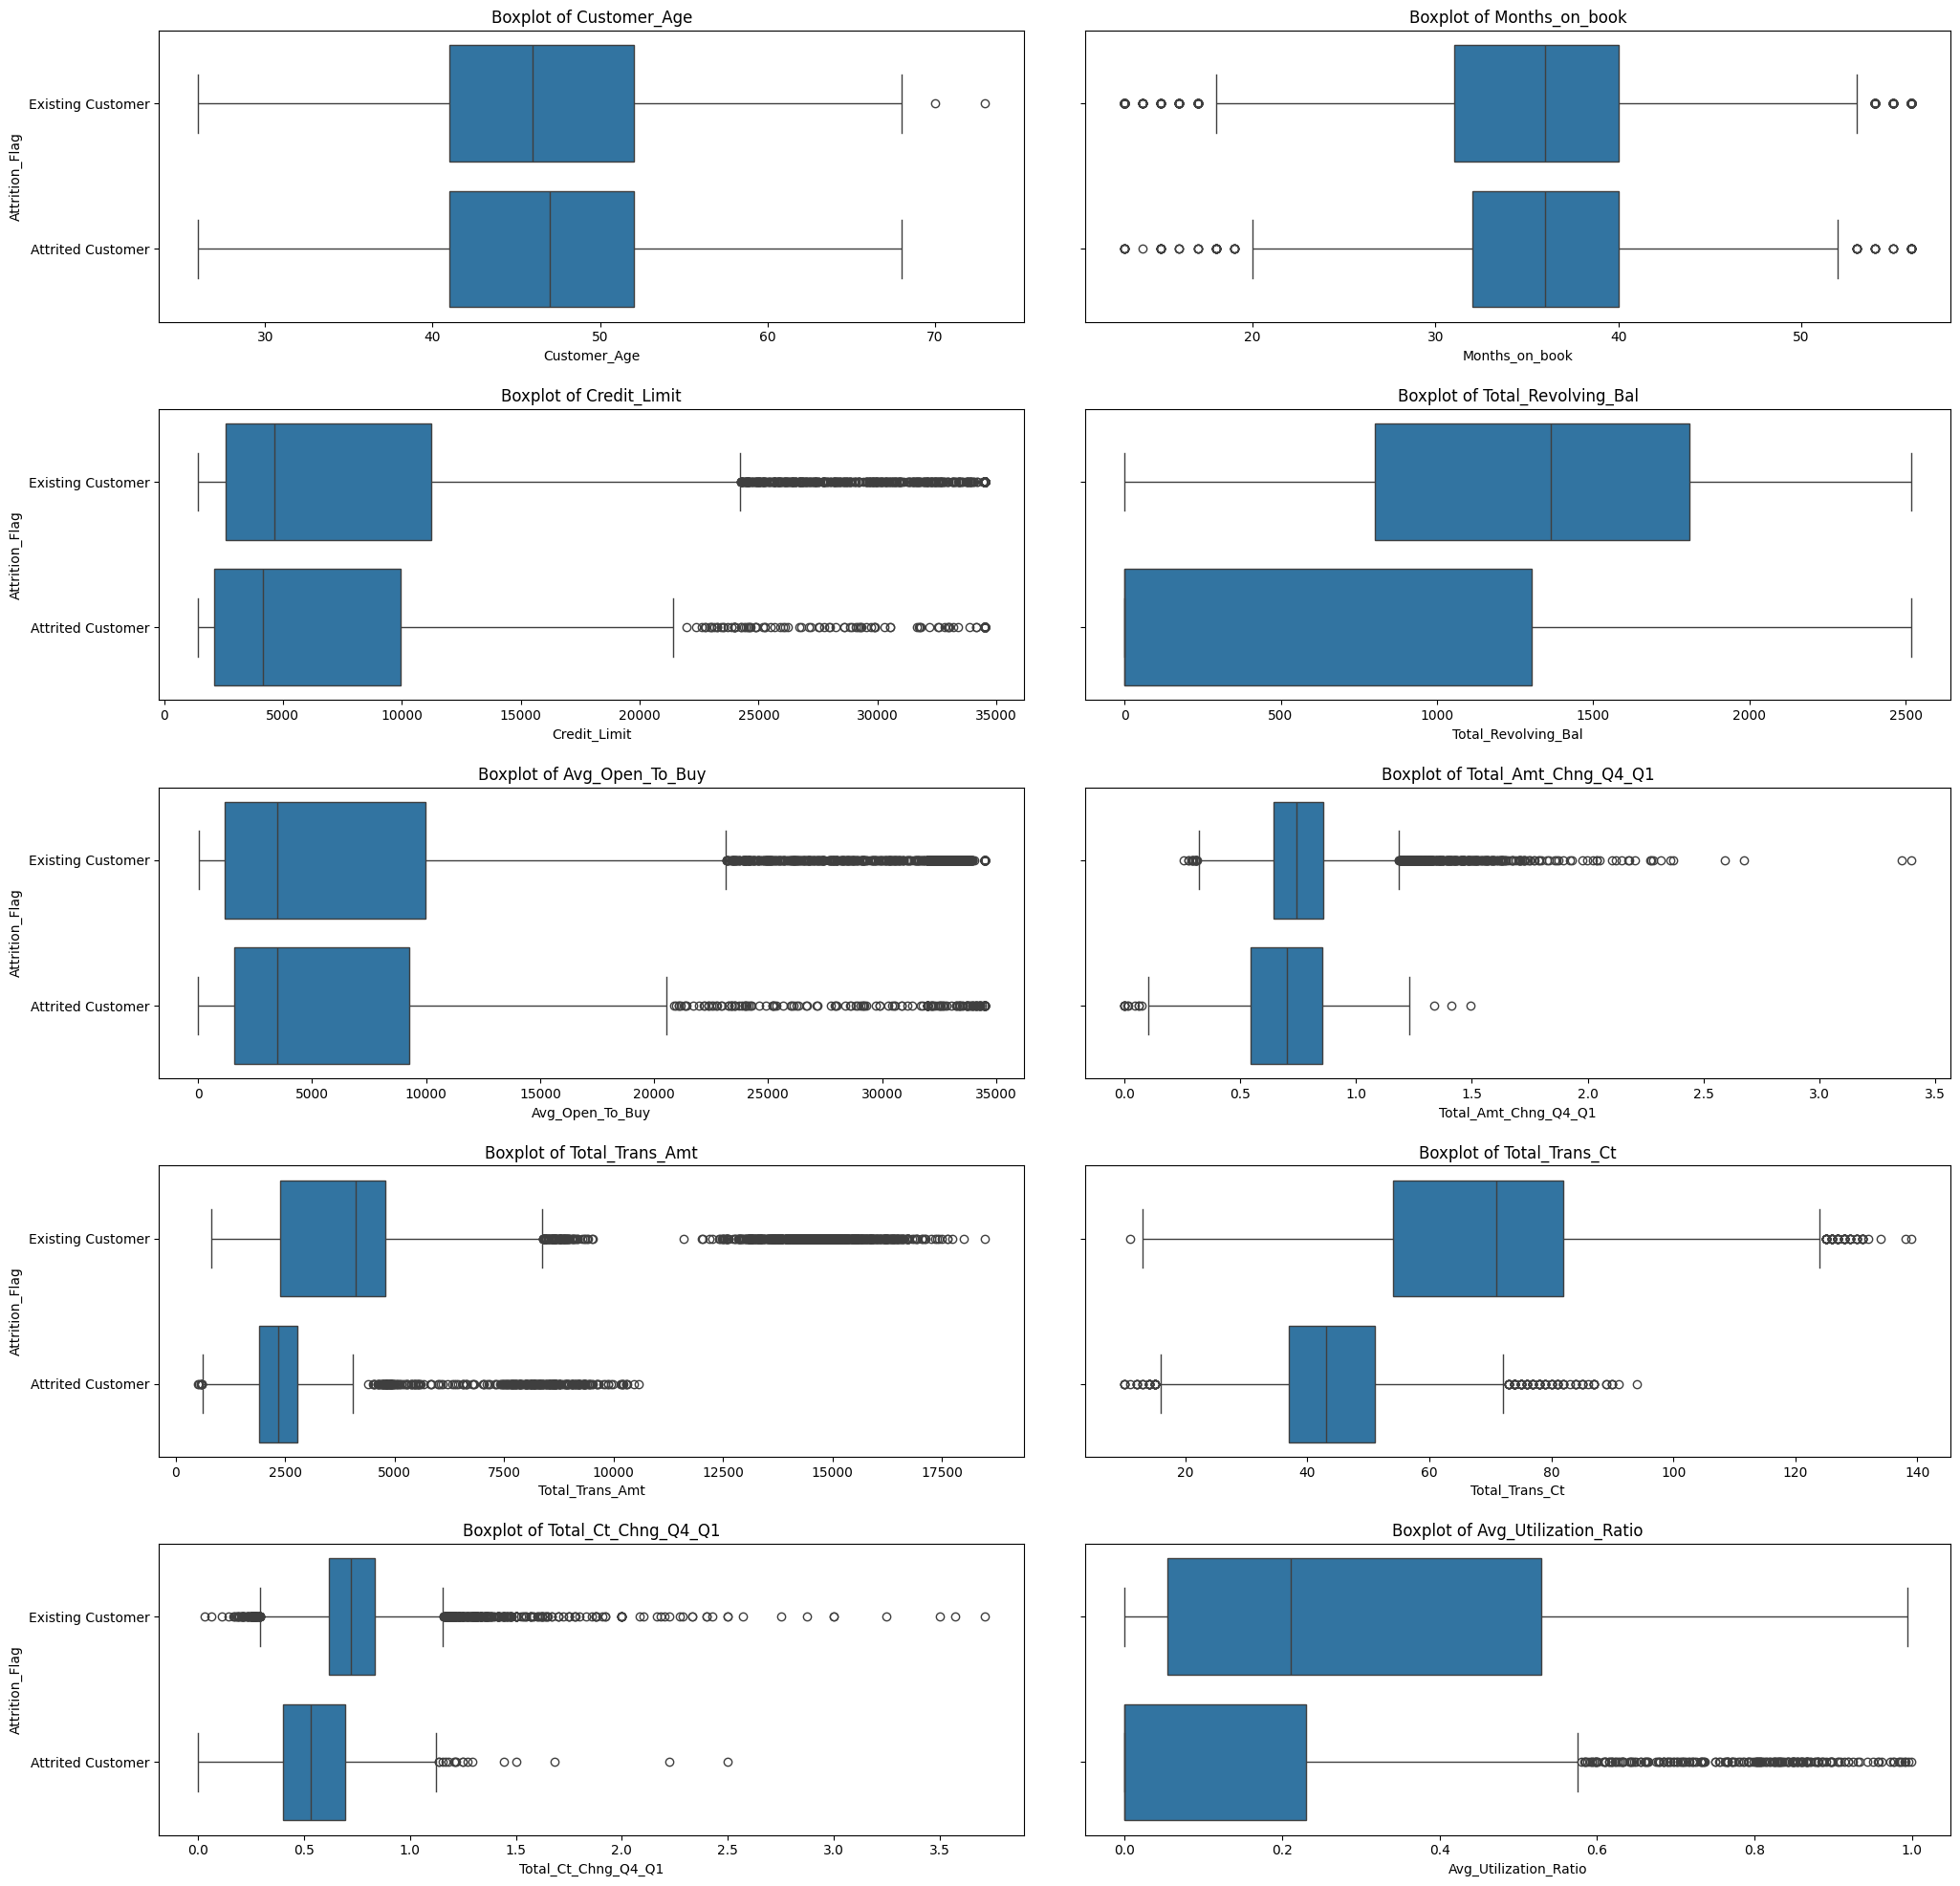

In [11]:
plot_boxplots_vscat(data,data['Attrition_Flag'])

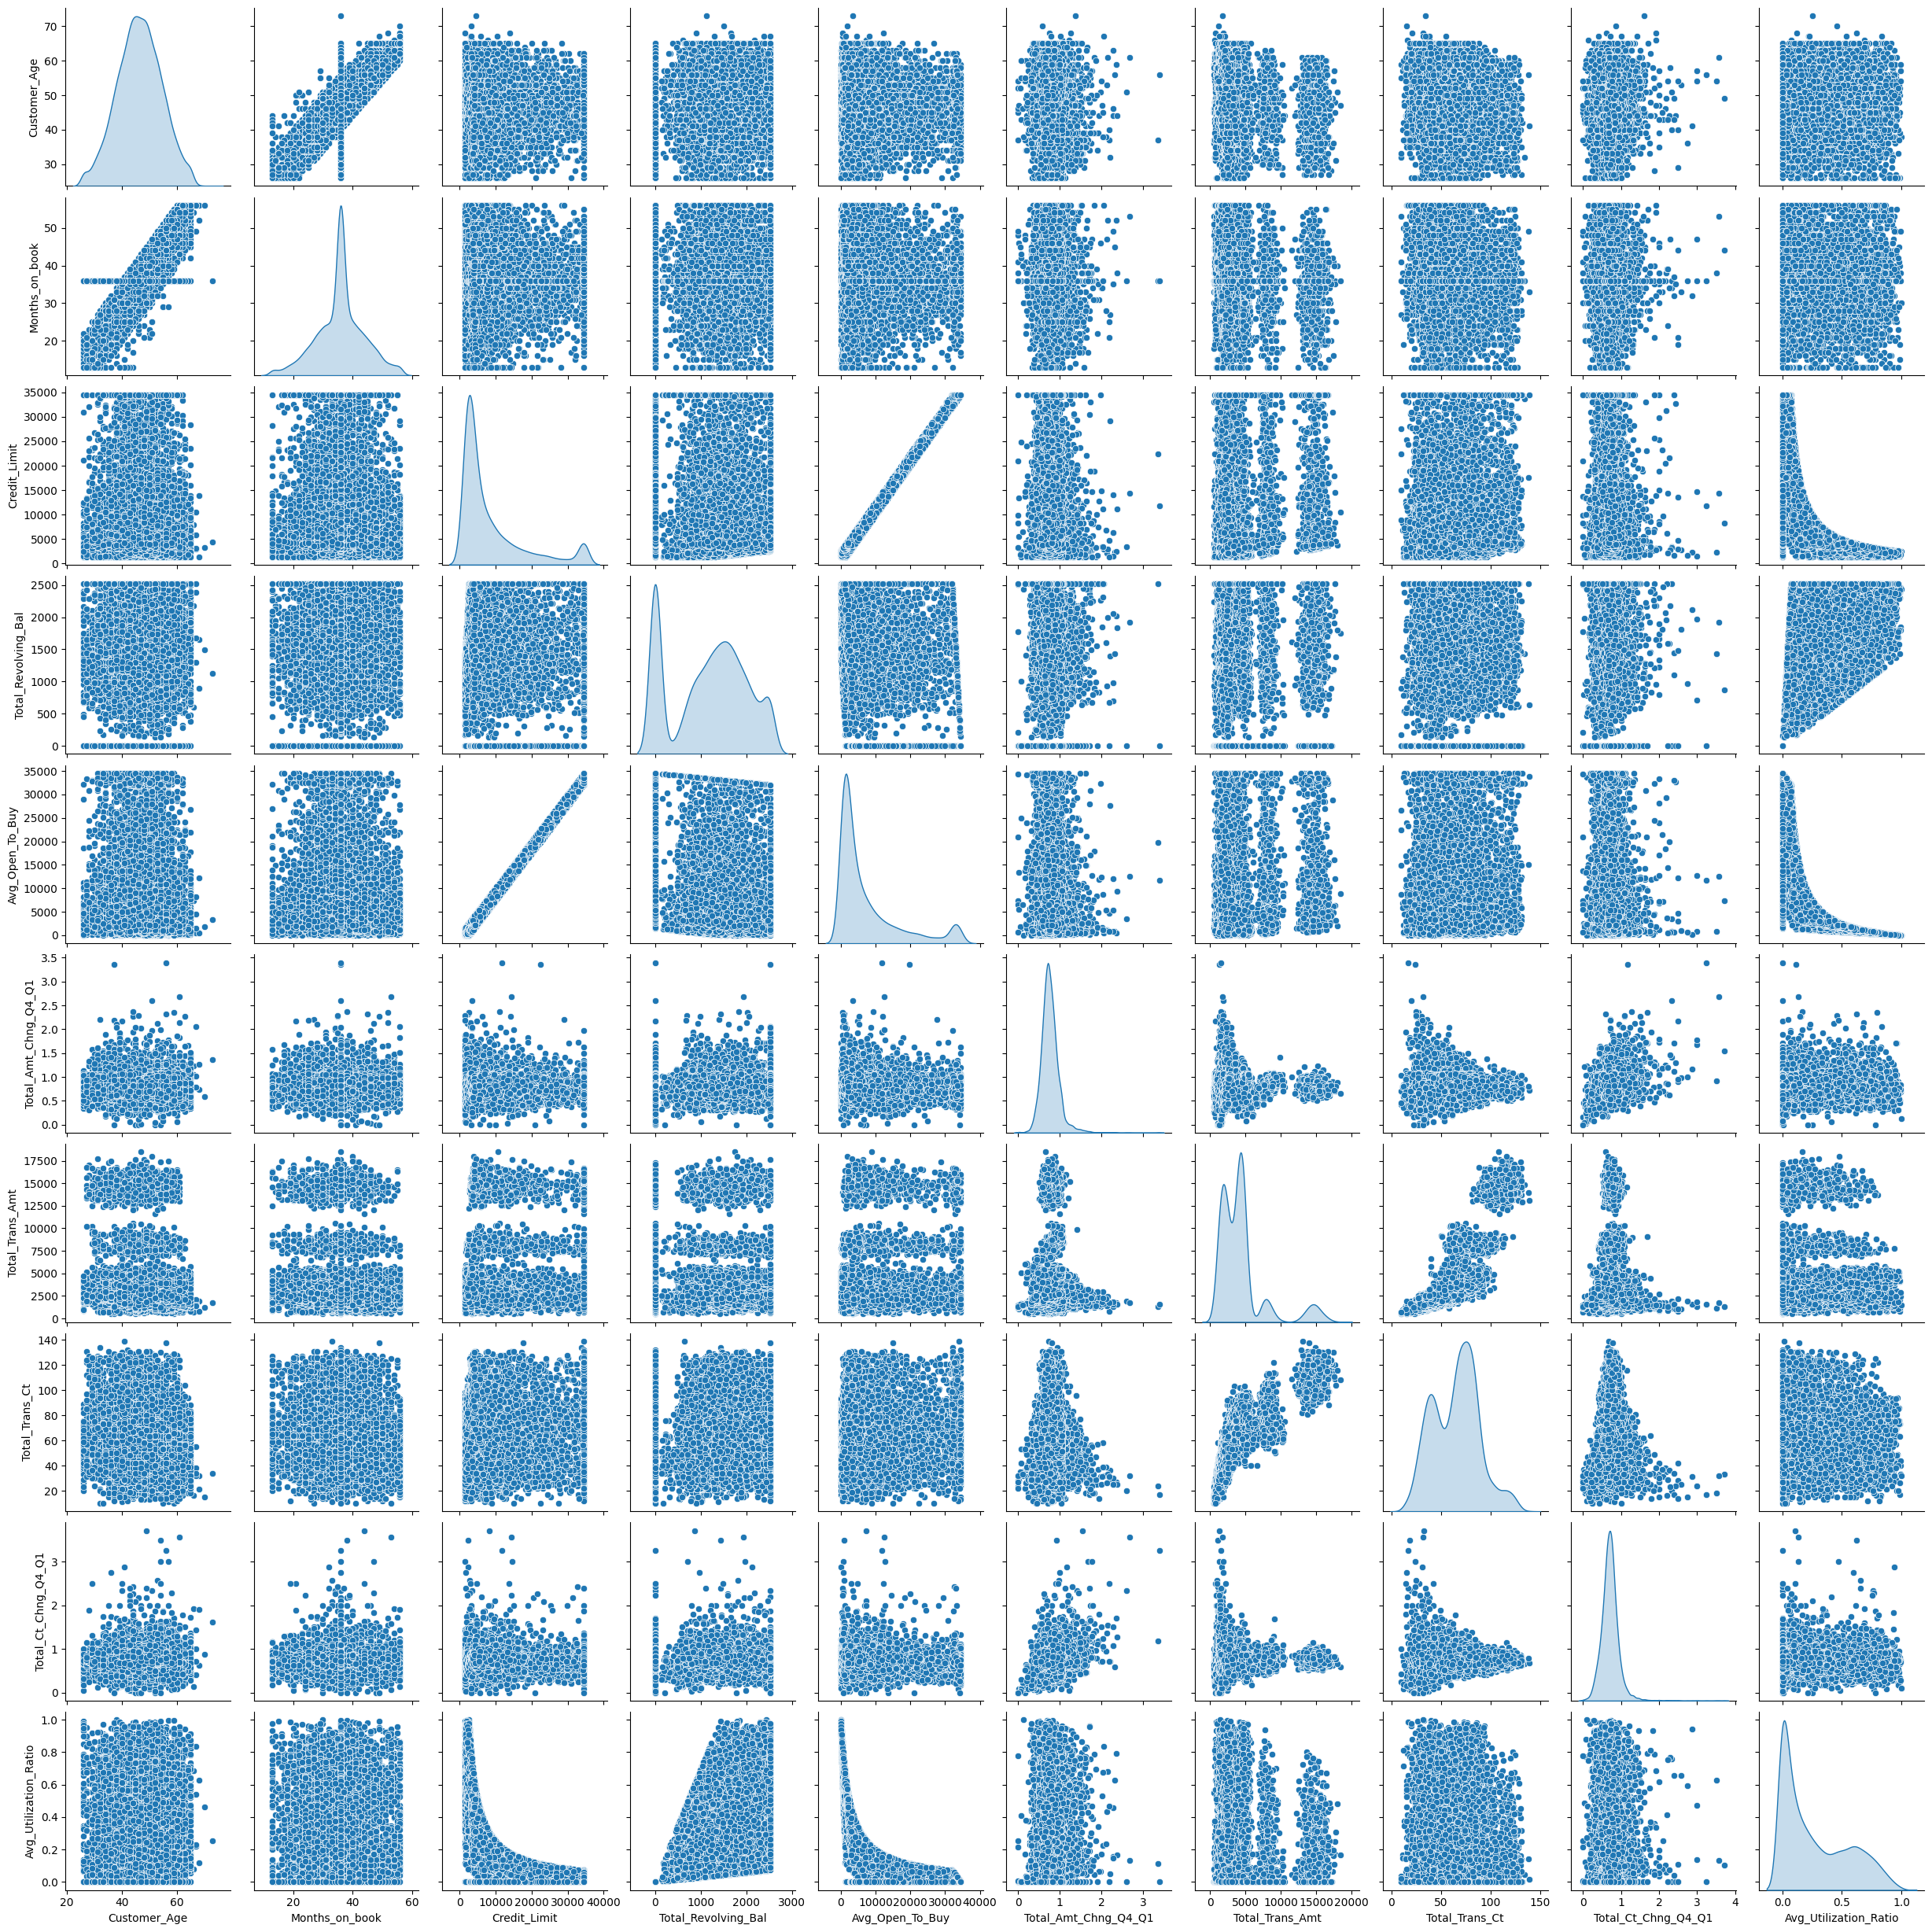

In [12]:
sns.pairplot(data, kind="scatter",diag_kind="kde")
plt.show()

In [13]:
# Desbalanceo de Clases
data['Attrition_Flag'].value_counts()

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

In [14]:
# Codificando Variable Objetivo para poder hacer matriz correlacion
data['Attrition_Flag'] = data['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})

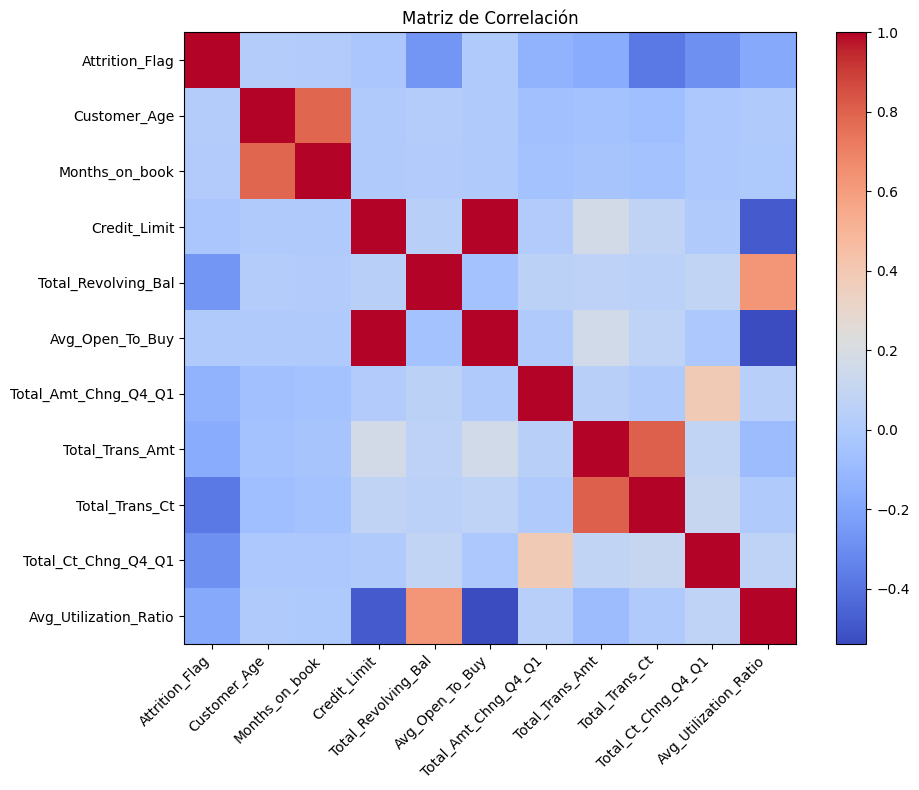

In [15]:
# Correlation matrix.
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
ax.set_title("Matriz de Correlación")

num_vars = len(corr_matrix.columns)
ax.set_xticks(np.arange(num_vars))
ax.set_yticks(np.arange(num_vars))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.index)

fig.colorbar(cax)
plt.tight_layout()
plt.show()

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 1)

### 2. Estimación del modelo usando una red neuronal con keras [30 puntos]

Estimen un modelo predictivo usando la muestra de entrenamiento y evalúen su desempeño en test con hiperparámetros de su selección.

In [16]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 2 ####


In [17]:
# Separación de las muestras
X = data.iloc[:, 1:]
y = data['Attrition_Flag']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.20,
    random_state=42,
    stratify=y_train_full
)
#Se escalan los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [18]:
seed_value = 123
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

input_dim = X_train.shape[1]
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [19]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [20]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC(name='auc')]
)

In [ ]:
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),  batch_size=25)

Epoch 1/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.5761 - loss: 0.6280 - val_auc: 0.7552 - val_loss: 0.3891
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7815 - loss: 0.3733 - val_auc: 0.8267 - val_loss: 0.3239
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8593 - loss: 0.3115 - val_auc: 0.8762 - val_loss: 0.2842
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9003 - loss: 0.2748 - val_auc: 0.9064 - val_loss: 0.2553
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.9207 - loss: 0.2519 - val_auc: 0.9212 - val_loss: 0.2390
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.9304 - loss: 0.2385 - val_auc: 0.9279 - val_loss: 0.2303
Epoch 7/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9355 - loss: 0.2300 - val_auc: 0.9321 - val_loss: 0.2246
Epoch 8/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9393 - loss: 0.2242 - val_auc: 0.9350 - val_loss: 0.2207
Epoch 9/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

Base Model Train Loss final: 0.149, Base Model Train AUC final: 0.974
Base Model Validation Loss final: 0.171, Base Model Validation AUC final: 0.963


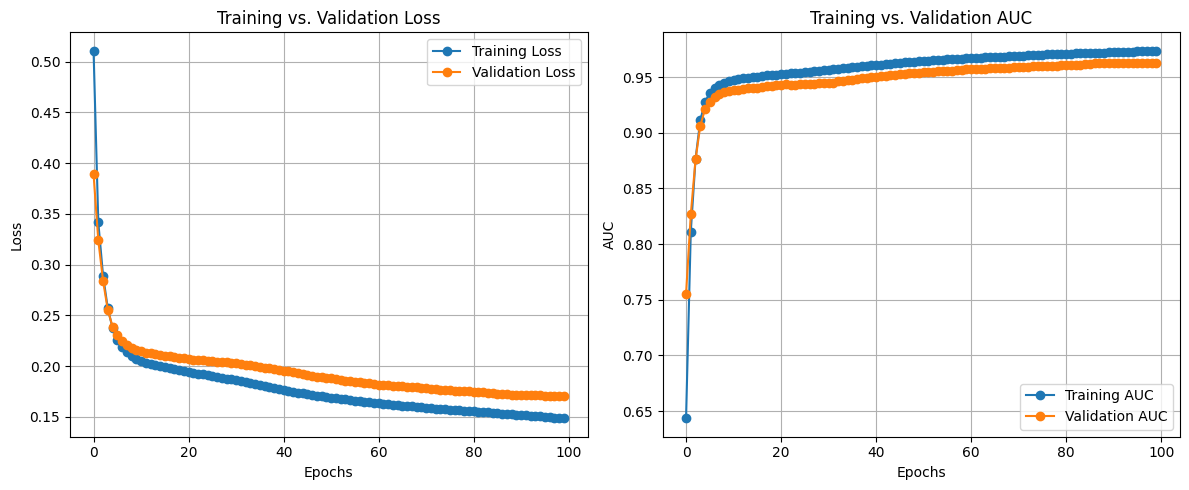

In [ ]:
# Imprimir el resultado final
print(f"Base Model Train Loss final: {history.history['loss'][-1]:.3f}, "
      f"Base Model Train AUC final: {history.history['auc'][-1]:.3f}")
print(f"Base Model Validation Loss final: {history.history['val_loss'][-1]:.3f}, "
      f"Base Model Validation AUC final: {history.history['val_auc'][-1]:.3f}")

plt.figure(figsize=(12, 5))

# Plot loss (error) on the left subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

# Plot precision on the right subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC', marker='o')
plt.plot(history.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model2 = Sequential([
    Input(shape=(input_dim,)),
    Dense(6, activation='tanh'),
    Dense(4, activation='selu'),
    Dense(2, activation='softplus'),
    Dense(1, activation='sigmoid')
])

model2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC(name='auc')]
)

history2=model2.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),  batch_size=25)

Epoch 1/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.4880 - loss: 0.8529 - val_auc: 0.7676 - val_loss: 0.5657
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8043 - loss: 0.4865 - val_auc: 0.8262 - val_loss: 0.3270
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8558 - loss: 0.3147 - val_auc: 0.8546 - val_loss: 0.3003
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8749 - loss: 0.2955 - val_auc: 0.8743 - val_loss: 0.2841
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8878 - loss: 0.2830 - val_auc: 0.8883 - val_loss: 0.2730
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8964 - loss: 0.2755 - val_auc: 0.8967 - val_loss: 0.2658
Epoch 7/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9013 - loss: 0.2708 - val_auc: 0.9027 - val_loss: 0.2607
Epoch 8/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9047 - loss: 0.2670 - val_auc: 0.9062 - val_loss: 0.2567
Epoch 9/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

Base Model Train Loss final: 0.168, Base Model Train AUC final: 0.965
Base Model Validation Loss final: 0.175, Base Model Validation AUC final: 0.961


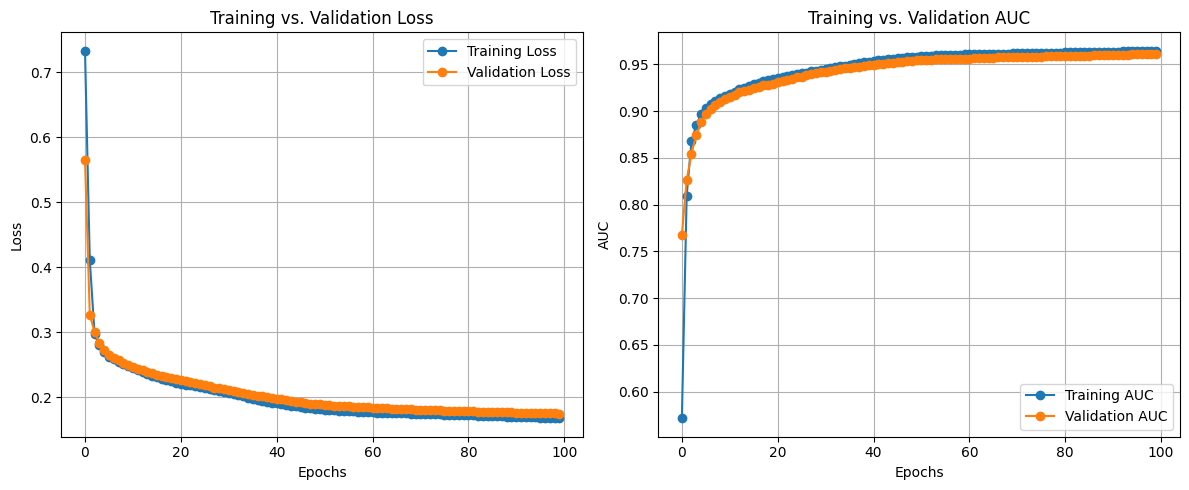

In [ ]:
# Imprimir el resultado final
print(f"Base Model Train Loss final: {history2.history['loss'][-1]:.3f}, "
      f"Base Model Train AUC final: {history2.history['auc'][-1]:.3f}")
print(f"Base Model Validation Loss final: {history2.history['val_loss'][-1]:.3f}, "
      f"Base Model Validation AUC final: {history2.history['val_auc'][-1]:.3f}")

plt.figure(figsize=(12, 5))

# Plot loss (error) on the left subplot
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

# Plot precision on the right subplot
plt.subplot(1, 2, 2)
plt.plot(history2.history['auc'], label='Training AUC', marker='o')
plt.plot(history2.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model3 = Sequential([
    Input(shape=(input_dim,)),
    Dense(6, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC(name='auc')]
)

history3=model3.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid),  batch_size=25)

Epoch 1/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - auc: 0.4363 - loss: 0.6890 - val_auc: 0.8106 - val_loss: 0.4943
Epoch 2/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.8193 - loss: 0.4546 - val_auc: 0.8571 - val_loss: 0.3493
Epoch 3/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8621 - loss: 0.3405 - val_auc: 0.8708 - val_loss: 0.3014
Epoch 4/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8772 - loss: 0.3046 - val_auc: 0.8801 - val_loss: 0.2859
Epoch 5/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8860 - loss: 0.2916 - val_auc: 0.8868 - val_loss: 0.2780
Epoch 6/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8913 - loss: 0.2847 - val_auc: 0.8917 - val_loss: 0.2729
Epoch 7/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8949 - loss: 0.2802 - val_auc: 0.8957 - val_loss: 0.2692
Epoch 8/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8980 - loss: 0.2771 - val_auc: 0.8989 - val_loss: 0.2663
Epoch 9/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

Base Model Train Loss final: 0.175, Base Model Train AUC final: 0.963
Base Model Validation Loss final: 0.180, Base Model Validation AUC final: 0.960


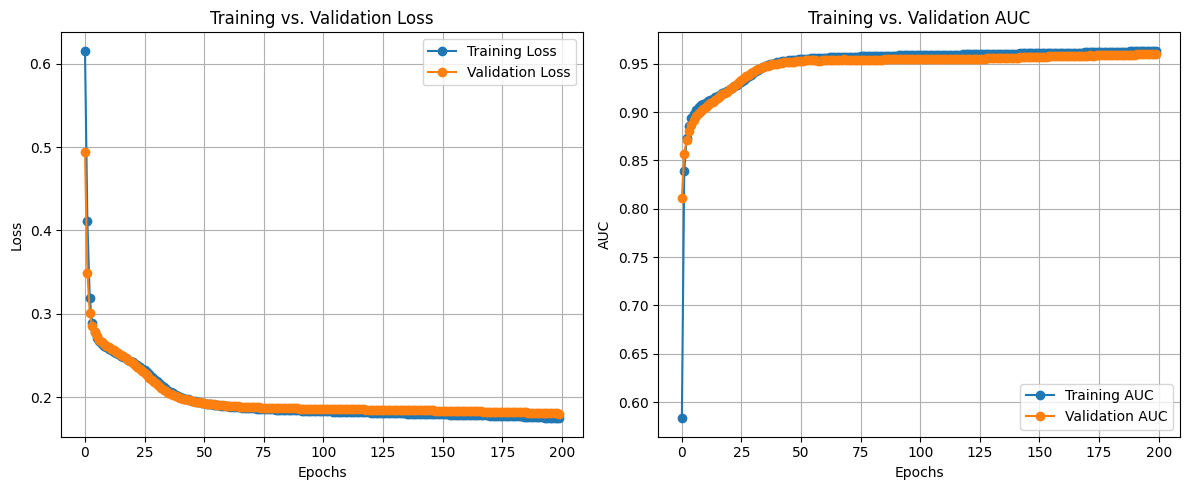

In [ ]:
# Imprimir el resultado final
print(f"Base Model Train Loss final: {history3.history['loss'][-1]:.3f}, "
      f"Base Model Train AUC final: {history3.history['auc'][-1]:.3f}")
print(f"Base Model Validation Loss final: {history3.history['val_loss'][-1]:.3f}, "
      f"Base Model Validation AUC final: {history3.history['val_auc'][-1]:.3f}")

plt.figure(figsize=(12, 5))

# Plot loss (error) on the left subplot
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss', marker='o')
plt.plot(history3.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

# Plot precision on the right subplot
plt.subplot(1, 2, 2)
plt.plot(history3.history['auc'], label='Training AUC', marker='o')
plt.plot(history3.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model4 = Sequential([
    Input(shape=(input_dim,)),
    Dense(12, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model4.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC(name='auc')]
)

history4=model4.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid),  batch_size=25)

Epoch 1/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc: 0.7116 - loss: 0.5894 - val_auc: 0.8592 - val_loss: 0.3763
Epoch 2/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.8649 - loss: 0.3503 - val_auc: 0.8764 - val_loss: 0.2995
Epoch 3/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8806 - loss: 0.3007 - val_auc: 0.8880 - val_loss: 0.2806
Epoch 4/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8902 - loss: 0.2864 - val_auc: 0.8964 - val_loss: 0.2707
Epoch 5/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8966 - loss: 0.2783 - val_auc: 0.9036 - val_loss: 0.2635
Epoch 6/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9024 - loss: 0.2724 - val_auc: 0.9091 - val_loss: 0.2575
Epoch 7/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9064 - loss: 0.2675 - val_auc: 0.9135 - val_loss: 0.2522
Epoch 8/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9106 - loss: 0.2630 - val_auc: 0.9179 - val_loss: 0.2472
Epoch 9/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

Base Model Train Loss final: 0.128, Base Model Train AUC final: 0.981
Base Model Validation Loss final: 0.141, Base Model Validation AUC final: 0.976


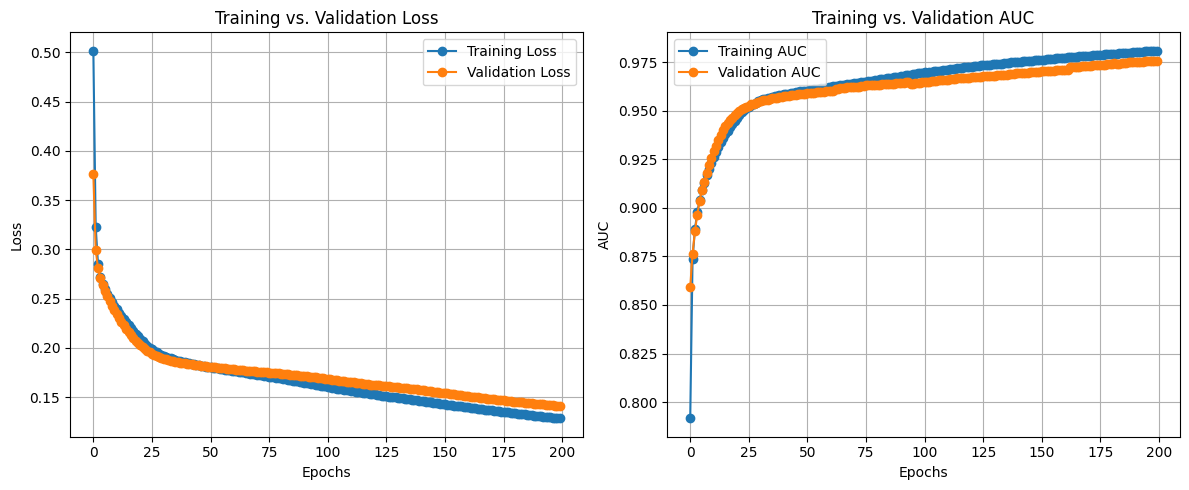

In [ ]:
# Imprimir el resultado final
print(f"Base Model Train Loss final: {history4.history['loss'][-1]:.3f}, "
      f"Base Model Train AUC final: {history4.history['auc'][-1]:.3f}")
print(f"Base Model Validation Loss final: {history4.history['val_loss'][-1]:.3f}, "
      f"Base Model Validation AUC final: {history4.history['val_auc'][-1]:.3f}")

plt.figure(figsize=(12, 5))

# Plot loss (error) on the left subplot
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training Loss', marker='o')
plt.plot(history4.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

# Plot precision on the right subplot
plt.subplot(1, 2, 2)
plt.plot(history4.history['auc'], label='Training AUC', marker='o')
plt.plot(history4.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model5 = Sequential([
    Input(shape=(input_dim,)),
    Dense(12, activation='softplus'),
    Dense(8, activation='relu'),
    Dense(6, activation='softplus'),
    Dense(4, activation='tanh'),
    Dense(4, activation='softsign'),
    Dense(2, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

model5.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC(name='auc')]
)

history5=model5.fit(X_train, y_train, epochs=150, validation_data=(X_valid, y_valid),  batch_size=25)

Epoch 1/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5685 - loss: 0.5102 - val_auc: 0.8009 - val_loss: 0.4087
Epoch 2/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc: 0.8037 - loss: 0.4046 - val_auc: 0.8017 - val_loss: 0.3667
Epoch 3/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8115 - loss: 0.3719 - val_auc: 0.7997 - val_loss: 0.3461
Epoch 4/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8135 - loss: 0.3550 - val_auc: 0.8243 - val_loss: 0.3364
Epoch 5/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8215 - loss: 0.3410 - val_auc: 0.8333 - val_loss: 0.3332
Epoch 6/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8540 - loss: 0.3312 - val_auc: 0.8501 - val_loss: 0.3201
Epoch 7/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8701 - loss: 0.3132 - val_auc: 0.8657 - val_loss: 0.3067
Epoch 8/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8764 - loss: 0.3019 - val_auc: 0.8692 - val_loss: 0.2960
Epoch 9/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

Base Model Train Loss final: 0.110, Base Model Train AUC final: 0.985
Base Model Validation Loss final: 0.128, Base Model Validation AUC final: 0.980


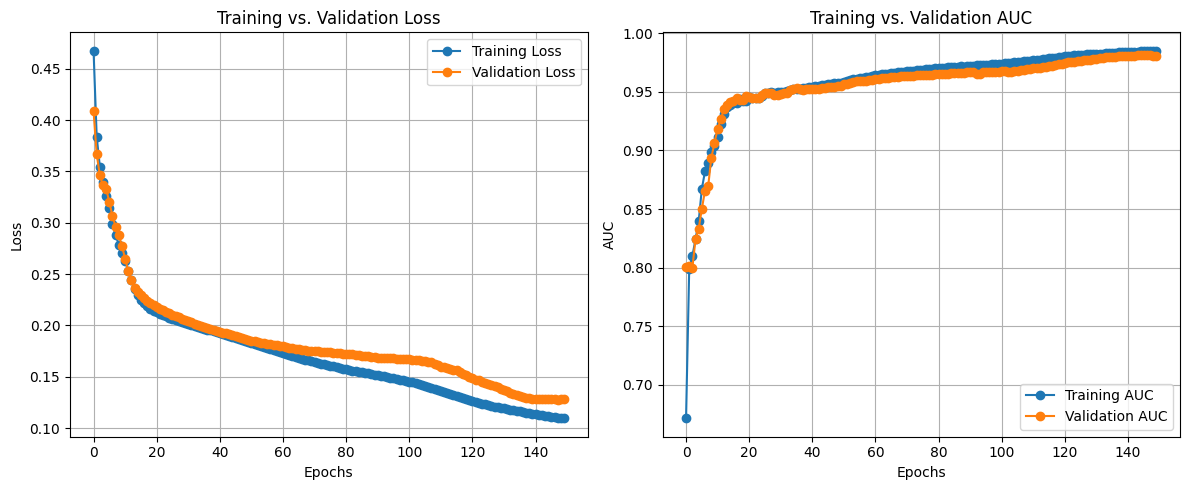

In [ ]:
# Imprimir el resultado final
print(f"Base Model Train Loss final: {history5.history['loss'][-1]:.3f}, "
      f"Base Model Train AUC final: {history5.history['auc'][-1]:.3f}")
print(f"Base Model Validation Loss final: {history5.history['val_loss'][-1]:.3f}, "
      f"Base Model Validation AUC final: {history5.history['val_auc'][-1]:.3f}")

plt.figure(figsize=(12, 5))

# Plot loss (error) on the left subplot
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Training Loss', marker='o')
plt.plot(history5.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

# Plot precision on the right subplot
plt.subplot(1, 2, 2)
plt.plot(history5.history['auc'], label='Training AUC', marker='o')
plt.plot(history5.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model6 = Sequential([
    Input(shape=(input_dim,)),
    Dense(12, activation='softplus'),
    Dense(4, activation='tanh'),
    Dense(4, activation='softsign'),
    Dense(1, activation='sigmoid')
])

model6.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC(name='auc')]
)

history6=model6.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid),  batch_size=25)

Epoch 1/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5946 - loss: 0.5307 - val_auc: 0.8003 - val_loss: 0.3751
Epoch 2/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8069 - loss: 0.3725 - val_auc: 0.8165 - val_loss: 0.3298
Epoch 3/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.8347 - loss: 0.3363 - val_auc: 0.8426 - val_loss: 0.3160
Epoch 4/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8604 - loss: 0.3181 - val_auc: 0.8673 - val_loss: 0.2951
Epoch 5/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8866 - loss: 0.2926 - val_auc: 0.8912 - val_loss: 0.2756
Epoch 6/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8986 - loss: 0.2760 - val_auc: 0.9068 - val_loss: 0.2628
Epoch 7/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9083 - loss: 0.2650 - val_auc: 0.9165 - val_loss: 0.2537
Epoch 8/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9161 - loss: 0.2564 - val_auc: 0.9232 - val_loss: 0.2462
Epoch 9/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

Base Model Train Loss final: 0.123, Base Model Train AUC final: 0.980
Base Model Validation Loss final: 0.146, Base Model Validation AUC final: 0.972


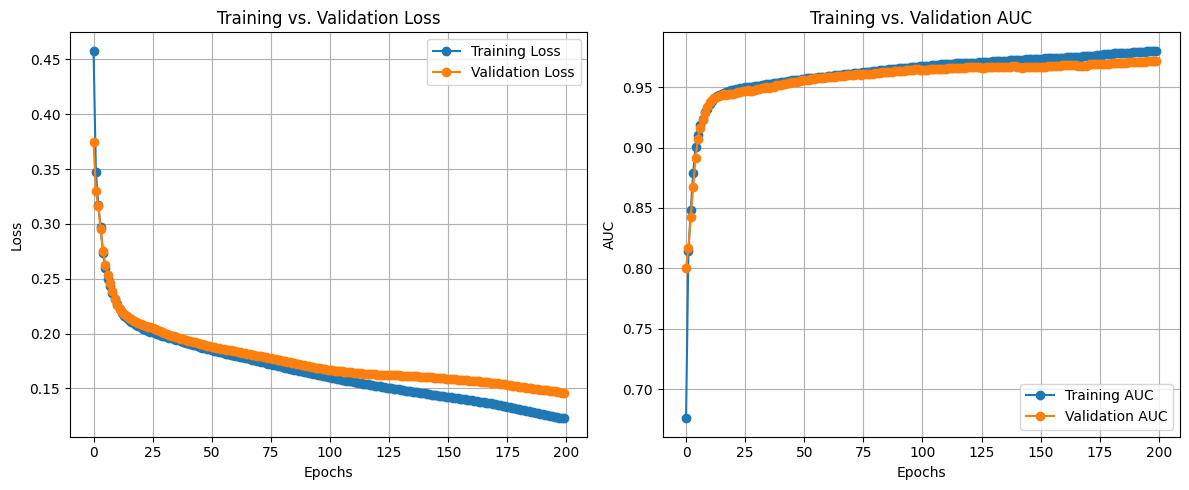

In [ ]:
# Imprimir el resultado final
print(f"Base Model Train Loss final: {history6.history['loss'][-1]:.3f}, "
      f"Base Model Train AUC final: {history6.history['auc'][-1]:.3f}")
print(f"Base Model Validation Loss final: {history6.history['val_loss'][-1]:.3f}, "
      f"Base Model Validation AUC final: {history6.history['val_auc'][-1]:.3f}")

plt.figure(figsize=(12, 5))

# Plot loss (error) on the left subplot
plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label='Training Loss', marker='o')
plt.plot(history6.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

# Plot precision on the right subplot
plt.subplot(1, 2, 2)
plt.plot(history6.history['auc'], label='Training AUC', marker='o')
plt.plot(history6.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 2)

### 3. Elección del mejor modelo [40 puntos]

Ahora construyan una función que reciba por parámetro una lista de número de capas a utilizar,  números de neuronas por capa, así como funciones de activación a utilizar.

Dicha función debe entrenar el modelo con los datos de entrenamiento, evaluar con los datos de prueba para cada una de las combinaciones de hiperparámetros y encontrar cuál es la mejor combinación de hiperprámetros.  

Una vez hecho este procedimiento respondan a la siguiente pregunta:

¿Cómo argumenta que esta sea la selección óptima de hiperparámetros?

In [ ]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 3 ####

In [ ]:
# Primera version de la función mejor modelo menor validation loss

from itertools import product

def model_train0(layers, neurons_options, activation_options,
                X_train, y_train, X_val, y_val,
                epochs=100, batch_size=25):
    """
    Trains multiple models based on all possible combinations for hidden layers.

    Parameters:
    - layers: int, number of hidden layers.
    - neurons_options: list of ints, each candidate neuron count for a hidden layer.
    - activation_options: list of strings, candidate activation functions for a hidden layer.
    - X_train, y_train: training data and labels.
    - X_val, y_val: validation data and labels.
    - epochs: int, number of training epochs (default 10).
    - batch_size: int, training batch size (default 32).

    Returns:
    - best_model: the trained Keras model with the lowest validation loss.
    - best_params: tuple representing the configuration (one tuple per layer) of the best model.
    - results: list of tuples with the configuration and corresponding validation loss.
    """
    best_val_loss = float('inf')
    best_model = None
    best_params = None
    results = []

    # Build grid of configurations for the hidden layers.
    # Each hidden layer is defined by a tuple: (neurons, activation)
    # For 'layers' hidden layers, we build the Cartesian product of these configurations.
    config_grid = list(product(product(neurons_options, activation_options), repeat=layers))
    print(f"Total configurations to try: {len(config_grid)}")

    for config in config_grid:
        seed_value = 123
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)

        # Build the model for the current configuration.
        model = keras.models.Sequential()
        model.add(keras.layers.Input(shape=(X_train.shape[1],)))

        # Add the hidden layers as per the current config.
        for neurons, activation in config:
            model.add(keras.layers.Dense(neurons, activation=activation))

        # Final output layer for binary classification.
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        # Compile the model. You can modify the metrics if needed.
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])

        # Train the model
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size,
                            shuffle=False,  # <-- Data shuffling controlled here
                            verbose=0) # silent training

        # Retrieve the final training and validation loss.
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        print(f"Config {config} -> Final Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}")
        results.append((config, val_loss))

        # Save the model if it's the best so far.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = config

    print(f"\nBest configuration: {best_params} with validation loss: {best_val_loss:.3f}")
    return best_model, best_params, results, config_grid

In [ ]:
# Correr la función
layers = 2
neurons_options = [12, 8]
activation_options = ['relu', 'tanh']

best_model0, best_params0, results0, config_grid0  = model_train0(layers, neurons_options, activation_options,
                                                 X_train, y_train, X_valid, y_valid,
                                                 epochs=100, batch_size=25)

print(best_model0)
print(config_grid0)

Total configurations to try: 16
Config ((12, 'relu'), (12, 'relu')) -> Final Train loss: 0.133, Validation loss: 0.169
Config ((12, 'relu'), (12, 'tanh')) -> Final Train loss: 0.101, Validation loss: 0.131
Config ((12, 'relu'), (8, 'relu')) -> Final Train loss: 0.121, Validation loss: 0.160
Config ((12, 'relu'), (8, 'tanh')) -> Final Train loss: 0.120, Validation loss: 0.146
Config ((12, 'tanh'), (12, 'relu')) -> Final Train loss: 0.099, Validation loss: 0.140
Config ((12, 'tanh'), (12, 'tanh')) -> Final Train loss: 0.092, Validation loss: 0.114
Config ((12, 'tanh'), (8, 'relu')) -> Final Train loss: 0.110, Validation loss: 0.145
Config ((12, 'tanh'), (8, 'tanh')) -> Final Train loss: 0.100, Validation loss: 0.129
Config ((8, 'relu'), (12, 'relu')) -> Final Train loss: 0.113, Validation loss: 0.140
Config ((8, 'relu'), (12, 'tanh')) -> Final Train loss: 0.100, Validation loss: 0.130
Config ((8, 'relu'), (8, 'relu')) -> Final Train loss: 0.133, Validation loss: 0.151
Config ((8, 'relu')

In [ ]:
# Segunda funcion enfocada en auc y penalizando overfitting, incluye historias para plotearlas luego
from itertools import product

def model_train1(layers, neurons_options, activation_options,
                X_train, y_train, X_val, y_val,
                epochs=10, batch_size=32, alpha=0.0):
    """
    Trains multiple models based on all possible combinations of hidden layer configurations,
    evaluates them using the auc metric, and selects the best one based on a composite score.

    The composite score is computed as:
        score = val_auc - alpha * abs(train_auc - val_auc)
    so that higher validation auc and a smaller difference between training and validation
    results (less overfitting) is preferable.

    Parameters:
      layers: int
          Number of hidden layers.
      neurons_options: list of ints
          Each candidate neuron count for a hidden layer.
      activation_options: list of strings
          Candidate activation functions for a hidden layer.
      X_train, y_train: array-like
          Training data and labels.
      X_val, y_val: array-like
          Validation data and labels.
      epochs: int, default 10
          Number of training epochs.
      batch_size: int, default 32
          Training batch size.
      alpha: float, default 0.0
          Weighting factor to penalize the gap between training and validation auc.

    Returns:
      best_model: The trained Keras model with the best composite score.
      best_params: The configuration (tuple of tuples) corresponding to the best model.
      results: A list of dictionaries, each containing the configuration and its performance:
               - config: configuration used
               - train_auc: final training auc
               - val_auc: final validation auc
               - auc_diff: absolute difference between train and validation auc
               - score: composite score computed as (val_auc - alpha * auc_diff)
      histories: A dictionary mapping the string representation of each configuration to its training history.
    """
    best_score = -float('inf')
    best_model = None
    best_params = None
    results = []
    histories = {}

    # Build a grid of configurations for the hidden layers:
    # Each hidden layer is defined by a tuple: (neurons, activation)
    # With "layers" hidden layers, we build the Cartesian product of these configurations.
    config_grid = list(product(product(neurons_options, activation_options), repeat=layers))
    print(f"Total configurations to try: {len(config_grid)}")

    for config in config_grid:
        seed_value = 123
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)

        # Build the model for the current configuration.
        model = keras.models.Sequential()
        # Add an input layer assuming X_train has shape (num_samples, num_features)
        model.add(keras.layers.Input(shape=(X_train.shape[1],)))

        # Add the hidden layers based on the current configuration.
        for neurons, activation in config:
            model.add(keras.layers.Dense(neurons, activation=activation))

        # Final output layer for binary classification.
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        # Compile the model with binary cross-entropy loss and track auc.
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[keras.metrics.AUC(name='auc')])

        # Train the model.
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size,
                            shuffle=False,  # <-- Data shuffling controlled here
                            verbose=0)

        # Get the final loss/auc values from training and validation.
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        train_auc = history.history['auc'][-1]
        val_auc = history.history['val_auc'][-1]
        auc_diff = abs(train_auc - val_auc)

        # Composite score: Higher val auc and lower difference is better.
        score = val_auc - alpha * auc_diff

        print(f"Config {config} -> Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f} | Train auc: {train_auc:.3f}, Val auc: {val_auc:.3f}, Diff: {auc_diff:.3f}, Score: {score:.3f}")

        # Record results.
        results.append({
            'config': config,
            'train_auc': train_auc,
            'val_auc': val_auc,
            'auc_diff': auc_diff,
            'score': score
        })

        # Save the training history for plotting purposes later.
        histories[str(config)] = history.history

        # Update the best model if this configuration has the highest composite score.
        if score > best_score:
            best_score = score
            best_model = model
            best_params = config

    print(f"\nBest configuration: {best_params} with Score: {best_score:.3f}")
    return best_model, best_params, results, histories, config_grid

In [ ]:
# Correr la función
layers = 2
neurons_options = [12, 8]
activation_options = ['relu', 'tanh']

best_model1, best_params1, results1, histories1, config_grid1  = model_train1(layers, neurons_options, activation_options,
                                                 X_train, y_train, X_valid, y_valid,
                                                 epochs=100, batch_size=25, alpha= 0)



Total configurations to try: 16
Config ((12, 'relu'), (12, 'relu')) -> Train loss: 0.133, Val loss: 0.169 | Train auc: 0.977, Val auc: 0.964, Diff: 0.013, Score: 0.964
Config ((12, 'relu'), (12, 'tanh')) -> Train loss: 0.101, Val loss: 0.131 | Train auc: 0.988, Val auc: 0.979, Diff: 0.008, Score: 0.979
Config ((12, 'relu'), (8, 'relu')) -> Train loss: 0.121, Val loss: 0.160 | Train auc: 0.981, Val auc: 0.968, Diff: 0.013, Score: 0.968
Config ((12, 'relu'), (8, 'tanh')) -> Train loss: 0.120, Val loss: 0.146 | Train auc: 0.982, Val auc: 0.974, Diff: 0.008, Score: 0.974
Config ((12, 'tanh'), (12, 'relu')) -> Train loss: 0.099, Val loss: 0.140 | Train auc: 0.988, Val auc: 0.977, Diff: 0.012, Score: 0.977
Config ((12, 'tanh'), (12, 'tanh')) -> Train loss: 0.092, Val loss: 0.114 | Train auc: 0.990, Val auc: 0.984, Diff: 0.005, Score: 0.984
Config ((12, 'tanh'), (8, 'relu')) -> Train loss: 0.110, Val loss: 0.145 | Train auc: 0.985, Val auc: 0.974, Diff: 0.011, Score: 0.974
Config ((12, 'tanh'

In [ ]:

print(config_grid1)

[((12, 'relu'), (12, 'relu')), ((12, 'relu'), (12, 'tanh')), ((12, 'relu'), (8, 'relu')), ((12, 'relu'), (8, 'tanh')), ((12, 'tanh'), (12, 'relu')), ((12, 'tanh'), (12, 'tanh')), ((12, 'tanh'), (8, 'relu')), ((12, 'tanh'), (8, 'tanh')), ((8, 'relu'), (12, 'relu')), ((8, 'relu'), (12, 'tanh')), ((8, 'relu'), (8, 'relu')), ((8, 'relu'), (8, 'tanh')), ((8, 'tanh'), (12, 'relu')), ((8, 'tanh'), (12, 'tanh')), ((8, 'tanh'), (8, 'relu')), ((8, 'tanh'), (8, 'tanh'))]


In [ ]:
# tercera funcion enfocada en validation loss y penalizando overfitting, incluye historias para plotearlas luego
from itertools import product

def model_train2(layers, neurons_options, activation_options,
                X_train, y_train, X_val, y_val,
                epochs=10, batch_size=32, alpha=0.0):
    """
    Trains multiple models based on all possible combinations of hidden layer configurations,
    and selects the best one based on a composite score that considers both the validation loss
    and the degree of overfitting (measured as the difference between training and validation loss).

    The composite score is calculated as:
        composite_score = validation_loss + alpha * |training_loss - validation_loss|

    Lower scores indicate better performance with less overfitting.

    Parameters:
      layers: int
          Number of hidden layers.
      neurons_options: list of ints
          Candidate neuron counts for each hidden layer.
      activation_options: list of strings
          Candidate activation functions for each hidden layer.
      X_train, y_train: array-like
          Training data and labels.
      X_val, y_val: array-like
          Validation data and labels.
      epochs: int, default 10
          Number of training epochs.
      batch_size: int, default 32
          Batch size for training.
      alpha: float, default 0.0
          Weighting factor to penalize the gap between training and validation loss.

    Returns:
      best_model: The trained Keras model with the lowest composite score.
      best_params: The configuration (tuple of tuples) for the best model.
      results: A list of dictionaries containing each configuration’s:
               - config: The configuration used.
               - train_loss: Final training loss.
               - val_loss: Final validation loss.
               - diff: Absolute difference between training and validation loss.
               - score: The composite score.
      histories: A dictionary mapping each configuration (as a string) to its training history.
    """
    best_score = float('inf')  # Because lower validation loss is better.
    best_model = None
    best_params = None
    results = []
    histories = {}

    # Construct the grid: Each hidden layer configuration is a tuple (neurons, activation).
    # With 'layers' hidden layers, we create a Cartesian product of these tuples.
    config_grid = list(product(product(neurons_options, activation_options), repeat=layers))
    print(f"Total configurations to try: {len(config_grid)}")

    for config in config_grid:
        seed_value = 123
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)

        # Build the model for the current configuration.
        model = keras.models.Sequential()
        # Add the input layer; assumes X_train shape is (num_samples, num_features).
        model.add(keras.layers.Input(shape=(X_train.shape[1],)))

        # Create hidden layers based on the configuration.
        for neurons, activation in config:
            model.add(keras.layers.Dense(neurons, activation=activation))

        # Final output layer: binary classification.
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        # Compile the model with binary cross-entropy loss.
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[keras.metrics.AUC(name='auc')])

        # Train the model.
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size,
                            shuffle=False,  # <-- Data shuffling controlled here
                            verbose=0)

        # Retrieve the final training and validation loss.
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        train_auc = history.history['auc'][-1]
        val_auc = history.history['val_auc'][-1]
        diff = abs(train_loss - val_loss)

        # Compute the composite score.
        composite_score = val_loss + alpha * diff

        print(f"Config {config} -> Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Diff: {diff:.3f}, Composite Score: {composite_score:.3f} | Train auc: {train_auc:.3f}, Val auc: {val_auc:.3f}")

        # Record the results.
        results.append({
            'config': config,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'diff': diff,
            'score': composite_score
        })

        # Save the training history (for later plotting, etc.).
        histories[str(config)] = history.history

        # Update best model if this configuration has a lower composite score.
        if composite_score < best_score:
            best_score = composite_score
            best_model = model
            best_params = config

    print(f"\nBest configuration: {best_params} with Composite Score: {best_score:.3f}")
    return best_model, best_params, results, histories, config_grid

In [ ]:
# Correr la función
layers = 2
neurons_options = [12, 8]
activation_options = ['relu', 'tanh']

best_model2, best_params2, results2, histories2, config_grid2  = model_train2(layers, neurons_options, activation_options,
                                                 X_train, y_train, X_valid, y_valid,
                                                 epochs=100, batch_size=25, alpha= 0)



Total configurations to try: 16
Config ((12, 'relu'), (12, 'relu')) -> Train loss: 0.133, Val loss: 0.169, Diff: 0.036, Composite Score: 0.169 | Train auc: 0.977, Val auc: 0.964
Config ((12, 'relu'), (12, 'tanh')) -> Train loss: 0.101, Val loss: 0.131, Diff: 0.030, Composite Score: 0.131 | Train auc: 0.988, Val auc: 0.979
Config ((12, 'relu'), (8, 'relu')) -> Train loss: 0.121, Val loss: 0.160, Diff: 0.040, Composite Score: 0.160 | Train auc: 0.981, Val auc: 0.968
Config ((12, 'relu'), (8, 'tanh')) -> Train loss: 0.120, Val loss: 0.146, Diff: 0.025, Composite Score: 0.146 | Train auc: 0.982, Val auc: 0.974
Config ((12, 'tanh'), (12, 'relu')) -> Train loss: 0.099, Val loss: 0.140, Diff: 0.041, Composite Score: 0.140 | Train auc: 0.988, Val auc: 0.977
Config ((12, 'tanh'), (12, 'tanh')) -> Train loss: 0.092, Val loss: 0.114, Diff: 0.022, Composite Score: 0.114 | Train auc: 0.990, Val auc: 0.984
Config ((12, 'tanh'), (8, 'relu')) -> Train loss: 0.110, Val loss: 0.145, Diff: 0.035, Composi

#### Evaluacion de los Modelos Obtenidos

In [ ]:
# Modelo0
# Evaluate the best model on the test dataset
m0_test_loss, m0_test_metric = best_model0.evaluate(X_test, y_test, verbose=1)

# If you compiled with a single metric (e.g., accuracy or auc),
# this call will return [loss, metric]. You can print them out:
print(f"Model0 Test Loss: {m0_test_loss:.3f}")
print(f"Model0 Test Metric: {m0_test_metric:.3f}")

32/32 [==============================] - 0s 360us/step - loss: 0.1203 - auc: 0.9825
Model0 Test Loss: 0.120
Model0 Test Metric: 0.983


In [ ]:
# Modelo1
# Evaluate the best model on the test dataset
m1_test_loss, m1_test_metric = best_model1.evaluate(X_test, y_test, verbose=1)

# If you compiled with a single metric (e.g., accuracy or auc),
# this call will return [loss, metric]. You can print them out:
print(f"Model1 Test Loss: {m1_test_loss:.3f}")
print(f"Model1 Test Metric: {m1_test_metric:.3f}")

32/32 [==============================] - 0s 380us/step - loss: 0.1203 - auc: 0.9825
Model1 Test Loss: 0.120
Model1 Test Metric: 0.983


In [ ]:
# Modelo2
# Evaluate the best model on the test dataset
m2_test_loss, m2_test_metric = best_model2.evaluate(X_test, y_test, verbose=1)

# If you compiled with a single metric (e.g., accuracy or auc),
# this call will return [loss, metric]. You can print them out:
print(f"Model2 Test Loss: {m2_test_loss:.3f}")
print(f"Model2 Test Metric: {m2_test_metric:.3f}")

32/32 [==============================] - 0s 328us/step - loss: 0.1203 - auc: 0.9825
Model2 Test Loss: 0.120
Model2 Test Metric: 0.983


#### Plots de los mejores modelos

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Plots training and validation loss and auc.

    Parameters:
      history: A dictionary containing keys:
          'loss', 'val_loss', 'auc', and 'val_auc'.
          (If a Keras History object is passed, its `.history` attribute will be used.)
    """
    # If history has an attribute 'history', use it; otherwise assume it's a dictionary.
    hist = history.history if hasattr(history, 'history') else history

    # Print the final metrics
    print(f"Train Loss final: {hist['loss'][-1]:.3f}, "
          f"Train AUC final: {hist['auc'][-1]:.3f}")
    print(f"Validation Loss final: {hist['val_loss'][-1]:.3f}, "
          f"Validation AUC final: {hist['val_auc'][-1]:.3f}")

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot loss on the left subplot
    plt.subplot(1, 2, 1)
    plt.plot(hist['loss'], label='Training Loss', marker='o')
    plt.plot(hist['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot auc on the right subplot
    plt.subplot(1, 2, 2)
    plt.plot(hist['auc'], label='Training AUC', marker='o')
    plt.plot(hist['val_auc'], label='Validation AUC', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title('Training vs. Validation AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Train Loss final: 0.092, Train AUC final: 0.990
Validation Loss final: 0.114, Validation AUC final: 0.984


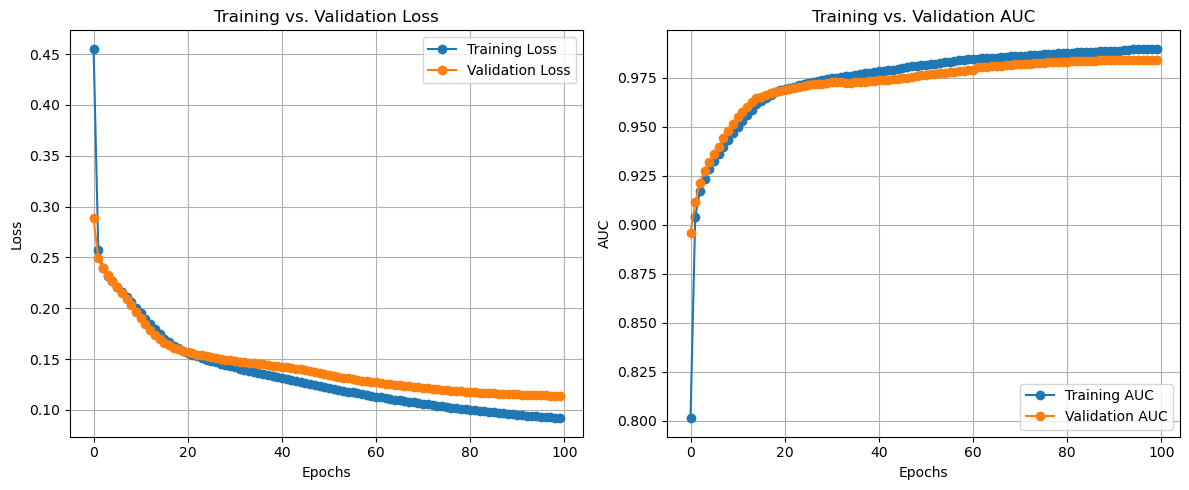

In [ ]:
# Plot model
best_history1 = histories1[str(best_params1)]
# Now, plot the history using our plot_history function
plot_history(best_history1)

Train Loss final: 0.092, Train AUC final: 0.990
Validation Loss final: 0.114, Validation AUC final: 0.984


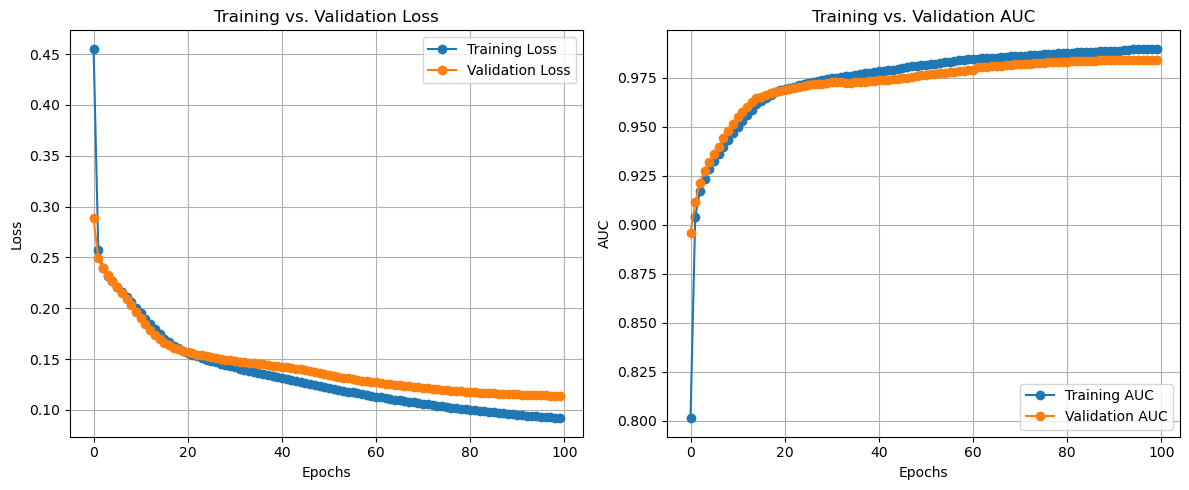

In [ ]:
# Plot model
best_history2 = histories2[str(best_params2)]
# Now, plot the history using our plot_history function
plot_history(best_history2)

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 3)